# Summary

## In this project, we review the paper [A Trainable Optimal Transport Embedding for Feature Aggregation and its Relationship to Attention](https://openreview.net/pdf?id=ZK6vTvb84s) written by Mialon et al.

## We will study the quality of the approximated 2-Wasserstein distance $W_2^z$ for a given random reference z with uniform weights on 1D distribution and 2D point clouds.

## We will design a 2-Wasserstein GAN [[Arkojvski, 2017]](https://arxiv.org/pdf/1701.07875.pdf) and adapt it using the approximation $W_2^z$.

## We will perform a logistic classification on the MNIST dataset using the OTK embeddings implemented in [GregoireMialon/OTK](https://github.com/GregoireMialon/OTK/tree/9c414d800476df2ad84fcf8042e717eb992e3370).

# Acknowledgement
## We reuse parts of code implemented in [Peyré Numerics Tours](https://nbviewer.org/github/gpeyre/numerical-tours/blob/master/python/optimaltransp_1_linprog.ipynb), [POT 1D](https://pythonot.github.io/auto_examples/plot_OT_1D.html#sphx-glr-auto-examples-plot-ot-1d-py), [WGAN](https://pythonot.github.io/auto_examples/backends/plot_wass2_gan_torch.html#sphx-glr-auto-examples-backends-plot-wass2-gan-torch-py)

# Import

In [ ]:
!pip install POT

import numpy as np
import matplotlib.pylab as pl
import matplotlib.animation as animation

import ot
import ot.plot
from ot.datasets import make_1D_gauss as gauss


import torch
from torch import nn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 682 kB 12.5 MB/s 


In [ ]:
SEED = 3407
np.random.seed(SEED)

# 1. Wasserstein Distance Approximation with 1D distributions

## Generate Data

In [ ]:
n = 100  # nb bins
m = 80 # nb bins
p = 50

# Bin positions
x = np.arange(n, dtype=np.float64)
y = np.arange(m, dtype=np.float64)
z = np.random.rand(p) 

# Weights
a = gauss(n, m=30, s=10) 
b = gauss(m, m=15, s=5)
c = np.ones((p,)) / p 

## Plot distributions



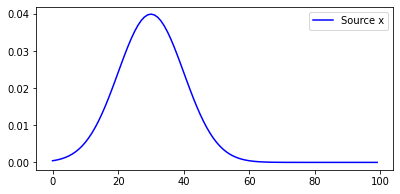

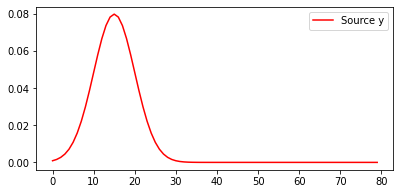

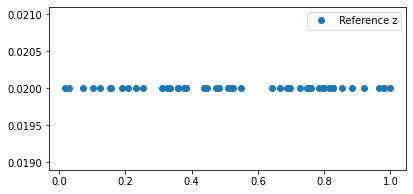

In [ ]:
pl.figure(1, figsize=(6.4, 3))
pl.plot(x, a, 'b', label='Source x')
pl.legend()
pl.show()
pl.figure(1, figsize=(6.4, 3))
pl.plot(y, b, 'r', label='Source y')
pl.legend()
pl.show()
pl.figure(1, figsize=(6.4, 3))
pl.plot(z, c, 'o', label='Reference z')
pl.legend()
pl.show()

## Compute and plot cost matrices
Compute the cost matrix $M_{i,j} := ||x_i-x_j||^2$.

In [ ]:
M_xy = ot.dist(x.reshape((n, 1)),y.reshape((m, 1)), metric='euclidean') ** 2
M_xz = ot.dist(x.reshape((n, 1)), z.reshape((p, 1)), metric='euclidean') ** 2
M_yz = ot.dist(y.reshape((m, 1)), z.reshape((p, 1)), metric='euclidean') ** 2

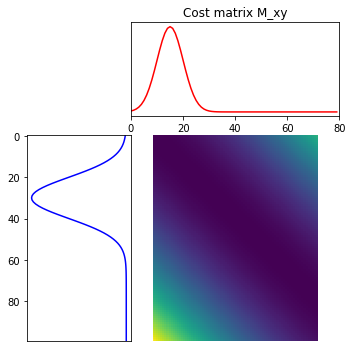

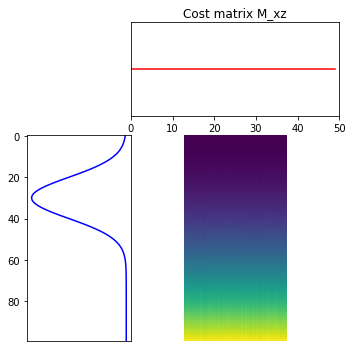

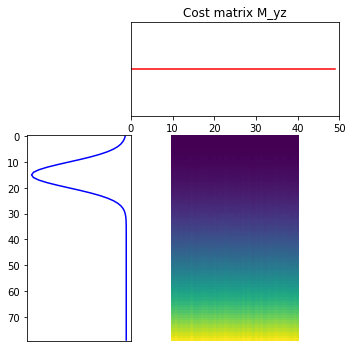

In [ ]:
pl.figure(1, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, M_xy, 'Cost matrix M_xy')
pl.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(a, c, M_xz, 'Cost matrix M_xz')
pl.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(b, c, M_yz, 'Cost matrix M_yz')

## Solve EMD

In [ ]:
# EMD
P_xy = ot.emd(a, b, M_xy)
P_xz = ot.emd(a, c, M_xz)
P_yz = ot.emd(b, c, M_yz)

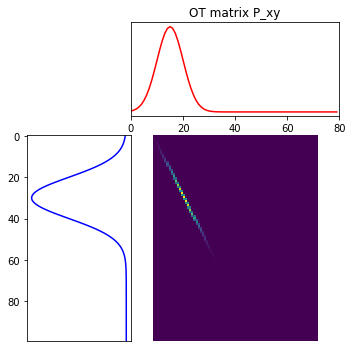

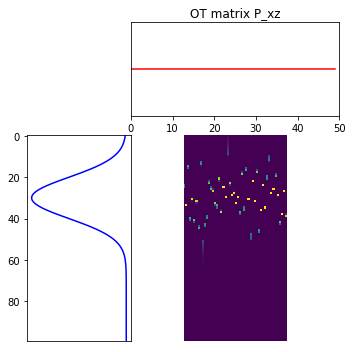

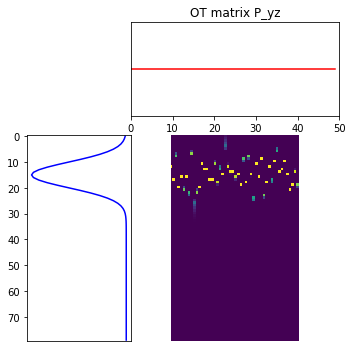

In [ ]:
pl.figure(1, figsize=(5, 5))
ot.plot.plot1D_mat(a, b, P_xy, 'OT matrix P_xy')
pl.figure(2, figsize=(5, 5))
ot.plot.plot1D_mat(a, c, P_xz, 'OT matrix P_xz')
pl.figure(3, figsize=(5, 5))
ot.plot.plot1D_mat(b, c, P_yz, 'OT matrix P_yz')

## Compute approximated matching $P_z$

Text(0.5, 1.0, 'Approximated OT matrix between X and Y')

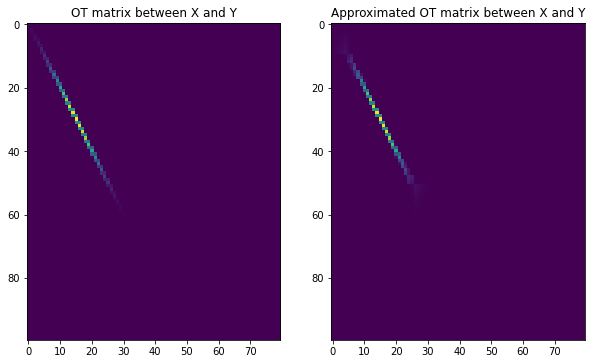

In [ ]:
P_approx = p * P_xz @ P_yz.T 

pl.figure(2, figsize=(10, 10))
pl.subplot(1, 2, 1)
pl.imshow(P_xy, interpolation='nearest')
pl.title('OT matrix between X and Y')
pl.subplot(1, 2, 2)
pl.imshow(P_approx, interpolation='nearest')
pl.title('Approximated OT matrix between X and Y')

## Evaluate Wasserstein approximation

In [ ]:
min_dist = lambda x,y: min(x,y)

def wasserstein_error(n, m, p, x, y, a, b):
  """ 
  Function to evaluate of wasserstein approximation
  between distribution x and y
  """

  # bin positions
  z = np.random.randn(p) 

  # Uniform weights: proof of the bound on the error requires to have uniform weights
  c = np.ones((p,)) / p 

  # Compute cost matrices
  M_xy = ot.dist(x.reshape((n, 1)),y.reshape((m, 1)), metric='euclidean') ** 2
  M_xz = ot.dist(x.reshape((n, 1)), z.reshape((p, 1)), metric='euclidean') ** 2
  M_yz = ot.dist(y.reshape((m, 1)), z.reshape((p, 1)), metric='euclidean') ** 2
 
  # # Compute optimal matching with EMD
  P_xy = ot.emd(a, b, M_xy)
  P_xz = ot.emd(a, c, M_xz)
  P_yz = ot.emd(b, c, M_yz)

  # Compute 2-wasserstein distances
  W2_xy = np.trace(P_xy.T @ M_xy) ** (1/2)
  W2_xz = np.trace(P_xz.T @ M_xz) ** (1/2)
  W2_yz = np.trace(P_yz.T @ M_yz) ** (1/2)

  bound = 2 * min_dist(W2_xz, W2_yz)

  # Compute approximated wasserstein distance
  P_approx = p * P_xz @ P_yz.T
  W2_approx = np.trace(P_approx.T @ M_xy) ** (1/2)

  # Compute error
  error = np.abs(W2_xy - W2_approx)
  
  return error, bound

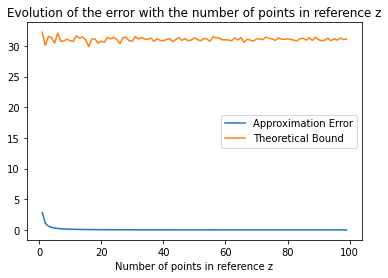

In [ ]:
n = 100  # nb bins
m = 80 # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)
y = np.arange(m, dtype=np.float64)

# Gaussian distributions
a = gauss(n, m=30, s=10) 
b = gauss(m, m=15, s=5)

errors = []
bounds = []
n_points = range(1,100)
for p in n_points:
  error, bound = wasserstein_error(n, m, p, x, y, a, b)
  errors.append(error)
  bounds.append(bound)

pl.plot(n_points, errors, label="Approximation Error")
pl.plot(n_points, bounds, label="Theoretical Bound")
pl.title('Evolution of the error with the number of points in reference z')
pl.xlabel('Number of points in reference z')
pl.legend()
pl.show()

## We showed empirically that $W_2^z(x,y) \leq 2 \min \{W_2(x,z), W_2(y,z)\}$.

# 2. Wasserstein distance approximation with 2D point clouds

## Generate point clouds

In [ ]:
normalize = lambda u: u/np.sum(u)
gaussian = lambda q,a,c: a*np.random.randn(2, q) + np.transpose(np.tile(c, (q,1)))

n = 100 
m = 80
p = 50 

# Bins positions
X = np.random.randn(n,2)*.1
Y = np.hstack((gaussian(int(m/2),.2,[0,1.6]),np.hstack((gaussian(int(m/4),.1,[-1,-1]),gaussian(int(m/4),.1,[1,-1])))))
Y = Y.T
theta = 2*np.pi*np.random.rand(1,p)
r = .6 + .2*np.random.rand(1,p)
Z = np.vstack((np.cos(theta)*r,np.sin(theta)*r)) # points inside an annulus
Z = Z.T

# Weights
a = normalize(np.random.rand(n,))
b = normalize(np.random.rand(m,))
c = np.ones((p,)) / p 

## Plot distributions



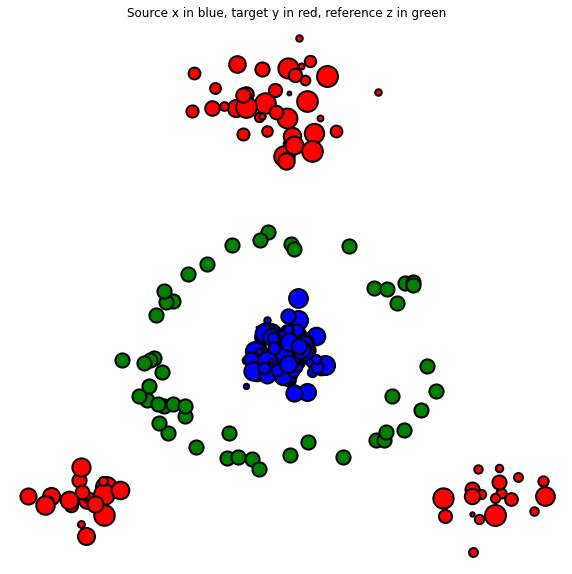

In [ ]:
myplot = lambda x,y,ms,col: pl.scatter(x,y, s=ms*20, edgecolors="k", c=col, linewidths=2)

pl.figure(figsize = (10,10))
pl.axis("off")
for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, 'r')
for k in range(len(c)):
    myplot(Z[k,0], Z[k,1], c[k]*len(c)*10, 'g')

pl.xlim(np.min(Y[:,0])-.1,np.max(Y[:,0])+.1)
pl.ylim(np.min(Y[:,1])-.1,np.max(Y[:,1])+.1)
pl.title('Source x in blue, target y in red, reference z in green')
pl.show()

## Compute and plot cost matrices

In [ ]:
# loss matrix
M_XY = ot.dist(X, Y, metric='euclidean') ** 2
M_XZ = ot.dist(X, Z, metric='euclidean') ** 2
M_YZ = ot.dist(Y, Z, metric='euclidean') ** 2

Text(0.5, 1.0, 'Cost matrix M_YZ')

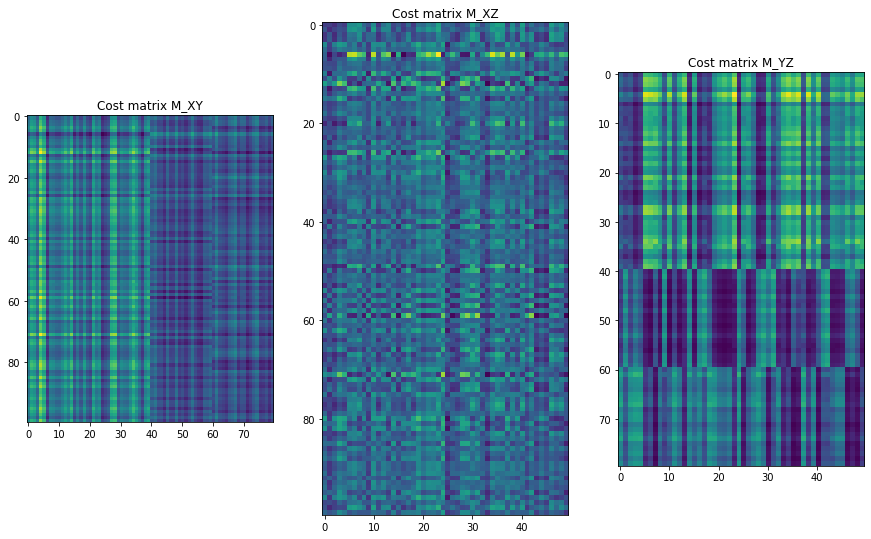

In [ ]:
pl.figure(2, figsize=(15, 10))
pl.subplot(1, 3, 1)
pl.imshow(M_XY, interpolation='nearest')
pl.title('Cost matrix M_XY')
pl.subplot(1, 3, 2)
pl.imshow(M_XZ, interpolation='nearest')
pl.title('Cost matrix M_XZ')
pl.subplot(1, 3, 3)
pl.imshow(M_YZ, interpolation='nearest')
pl.title('Cost matrix M_YZ')

## Solve EMD

In [ ]:
# EMD
P_XY = ot.emd(a, b, M_XY)
P_XZ = ot.emd(a, c, M_XZ)
P_YZ = ot.emd(b, c, M_YZ)

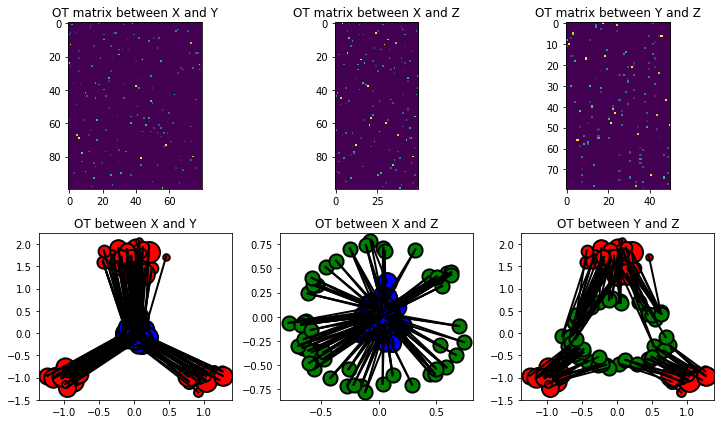

In [ ]:
pl.figure(2, figsize=(10, 6))

pl.subplot(2, 3, 1)
pl.imshow(P_XY, interpolation='nearest')
pl.title('OT matrix between X and Y')

pl.subplot(2, 3, 2)
pl.imshow(P_XZ, interpolation='nearest')
pl.title('OT matrix between X and Z')

pl.subplot(2, 3, 3)
pl.imshow(P_YZ, interpolation='nearest')
pl.title('OT matrix between Y and Z')

pl.subplot(2, 3, 4)
I,J = np.nonzero(P_XY>1e-5)
for k in range(len(I)):
    h = pl.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'k', lw = 2)
for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, 'r')
pl.title('OT between X and Y')

pl.subplot(2, 3, 5)
I,J = np.nonzero(P_XZ>1e-5)
for k in range(len(I)):
    h = pl.plot(np.hstack((X[I[k],0],Z[J[k],0])),np.hstack(([X[I[k],1], Z[J[k],1]])),'k', lw = 2)
for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*10, 'b')
for j in range(len(c)):
    myplot(Z[j,0], Z[j,1], c[j]*len(c)*10, 'g')
pl.title('OT between X and Z')

pl.subplot(2, 3, 6)
I,J = np.nonzero(P_YZ>1e-5)
for k in range(len(I)):
    h = pl.plot(np.hstack((Y[I[k],0],Z[J[k],0])),np.hstack(([Y[I[k],1], Z[J[k],1]])),'k', lw = 2)
for i in range(len(b)):
    myplot(Y[i,0], Y[i,1], b[i]*len(b)*10, 'r')
for j in range(len(c)):
    myplot(Z[j,0], Z[j,1], c[j]*len(c)*10, 'g')
pl.title('OT between Y and Z')
pl.tight_layout()

## Compute approximated matching $P_z$

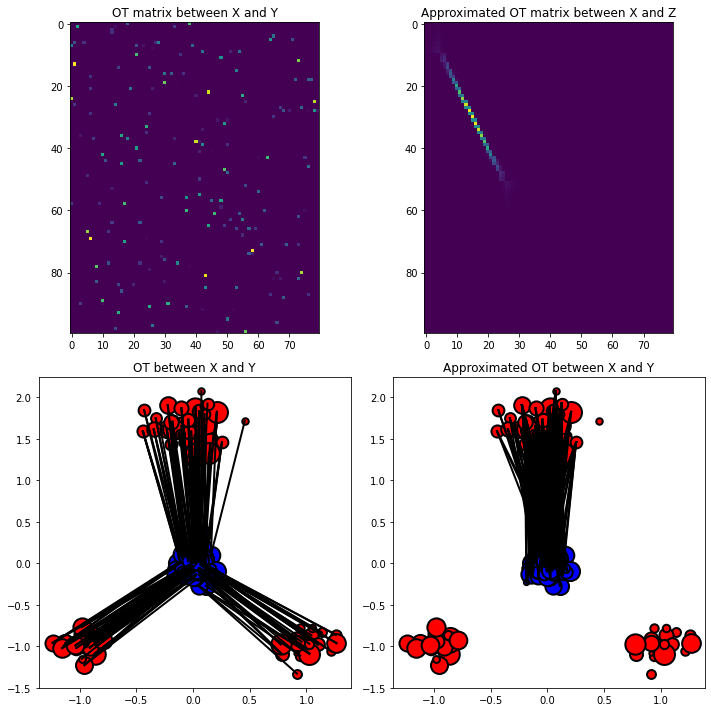

In [ ]:
pl.figure(2, figsize=(10, 10))

pl.subplot(2, 2, 1)
pl.imshow(P_XY, interpolation='nearest')
pl.title('OT matrix between X and Y')

pl.subplot(2, 2, 2)
pl.imshow(P_approx, interpolation='nearest')
pl.title('Approximated OT matrix between X and Z')

pl.subplot(2, 2, 3)
I,J = np.nonzero(P_XY>1e-5)
for k in range(len(I)):
    h = pl.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'k', lw = 2)
for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, 'r')
pl.title('OT between X and Y')

pl.subplot(2, 2, 4)
I,J = np.nonzero(P_approx>1e-5)
for k in range(len(I)):
    h = pl.plot(np.hstack((X[I[k],0],Y[J[k],0])),np.hstack(([X[I[k],1], Y[J[k],1]])),'k', lw = 2)
for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, 'r')
pl.title('Approximated OT between X and Y')
pl.tight_layout()

In [ ]:
min_dist = lambda x,y: min(x,y)

def wasserstein_2D_error(n, m, p, X, Y, a, b):
  """ 
  Function to evaluate of wasserstein approximation
  between distribution x and y
  """

  # bin positions
  theta = 2*np.pi*np.random.rand(1,p)
  r = .6 + .2*np.random.rand(1,p)
  Z = np.vstack((np.cos(theta)*r,np.sin(theta)*r)) # red points inside an anulus
  Z = Z.T

  # Weights
  c = np.ones((p,)) / p #normalize(np.random.rand(p,))

  # Compute cost matrices
  M_XY = ot.dist(X, Y, metric='euclidean') ** 2
  M_XZ = ot.dist(X, Z, metric='euclidean') ** 2
  M_YZ = ot.dist(Y, Z, metric='euclidean') ** 2

  # # Compute optimal matching with EMD
  P_XY = ot.emd(a, b, M_XY)
  P_XZ = ot.emd(a, c, M_XZ)
  P_YZ = ot.emd(b, c, M_YZ)

  # Compute 2-wasserstein distances
  W2_XY = np.trace(P_XY.T @ M_XY) ** (1/2)
  W2_XZ = np.trace(P_XZ.T @ M_XZ) ** (1/2)
  W2_YZ = np.trace(P_YZ.T @ M_YZ) ** (1/2)

  bound = 2 * min_dist(W2_XZ, W2_YZ)

  # Compute approximated wasserstein distance
  P_approx = p * P_XZ @ P_YZ.T  
  W2_approx = np.trace(P_approx.T @ M_XY) ** (1/2)

  # Compute error
  error = np.abs(W2_XY - W2_approx)
  
  return error, bound

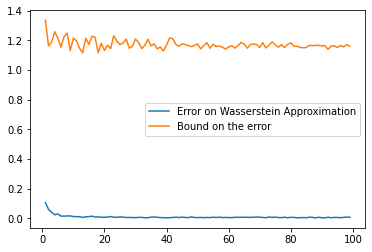

In [ ]:
n = 100
m = 80

X = np.random.randn(n,2)*.1
Y = np.hstack((gaussian(int(m/2),.2,[0,1.6]),np.hstack((gaussian(int(m/4),.1,[-1,-1]),gaussian(int(m/4),.1,[1,-1])))))
Y = Y.T

# Weights
a = normalize(np.random.rand(n,))
b = normalize(np.random.rand(m,))

errors = []
bounds = []
n_points = range(1,100)
for p in n_points:
  error, bound = wasserstein_2D_error(n, m, p, X, Y, a, b)
  errors.append(error)
  bounds.append(bound)

pl.plot(n_points, errors, label="Error on Wasserstein Approximation")
pl.plot(n_points, bounds, label="Bound on the error")
pl.legend()

## We showed empirically that $W_2^z(x,y) \leq 2 \min \{W_2(x,z), W_2(y,z)\}$.


# Wasserstein GAN

In this example inspired from [POT Wasserstein GAN](https://pythonot.github.io/auto_examples/backends/plot_wass2_gan_torch.html#sphx-glr-auto-examples-backends-plot-wass2-gan-torch-py), we train a Wasserstein GAN using 2-Wasserstein on minibatches
as a distribution fitting term.

We want to train a generator $G_\theta$ that generates realistic
data from random noise drawn from a Gaussian $\mu_n$ distribution so
that the data is indistinguishable from true data in the data distribution
$\mu_d$. To this end, Wasserstein GAN aims at optimizing
the parameters $\theta$ of the generator with the following
optimization problem:

\begin{align}\min_{\theta} W(\mu_d, G_\theta\#\mu_n)\end{align}

We will compare vanilla Wasserstein GAN with a GAN where the Wasserstein Distance is approximated by $W_2^z$ as proposed in [[Mialon, 2021]](https://openreview.net/pdf?id=ZK6vTvb84s) with $z$ a reference of $p$ points.

We will evaluate the quality of the approximation when p evolves.

## Data generation



In [ ]:
sigma = 0.1
n_dims = 2
n_features = 2

def get_data(n_samples):
    c = torch.rand(size=(n_samples, 1))
    angle = c * 2 * np.pi
    x = torch.cat((torch.cos(angle), torch.sin(angle)), 1)
    x += torch.randn(n_samples, 2) * sigma
    return x

def get_random(m_samples):
  y = torch.randn(m_samples,2)
  return y

def get_reference(p):
    theta = 2*np.pi*np.random.rand(1,p)
    r = .4 + .2*np.random.rand(1,p)
    z = np.vstack((np.cos(theta)*r,np.sin(theta)*r)) # points inside an annulus
    return torch.Tensor(z.T)

## Plot data and reference



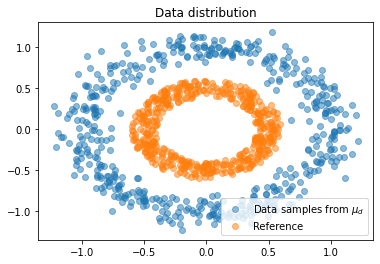

In [ ]:
# plot the distributions
n_samples = 500
x = get_data(n_samples)
p = 500
z = get_reference(p)
pl.figure(1)
pl.scatter(x[:, 0], x[:, 1], label='Data samples from $\mu_d$', alpha=0.5)
pl.scatter(z[:, 0], z[:, 1], label='Reference', alpha=0.5)
pl.title('Data distribution')
pl.legend(loc='lower right')
pl.show()


## Generator Model



In [ ]:
# define the MLP model
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(n_features, 200)
        self.fc2 = nn.Linear(200, 500)
        self.fc3 = nn.Linear(500, n_dims)
        self.relu = torch.nn.ReLU()  # instead of Heaviside step fn

    def forward(self, x):
        output = self.fc1(x)
        output = self.relu(output)  # instead of Heaviside step fn
        output = self.fc2(output)
        output = self.relu(output)
        output = self.fc3(output)
        return output

## Training the model



In [ ]:
def WGAN():

    G = Generator()
    optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5)

    # number of iteration and size of the batches
    n_iter = 200  
    size_batch = 500

    # generate statis samples to see their trajectory along training
    n_visu = 100
    xnvisu = get_random(n_visu) 
    xvisu = torch.zeros(n_iter, n_visu, n_dims)

    ab = torch.ones(size_batch) / size_batch
    losses = []

    for i in range(n_iter):

        # generate noise samples
        xn = get_random(size_batch) 

        # generate data samples
        xd = get_data(size_batch)

        # generate sample along iterations
        xvisu[i, :, :] = G(xnvisu).detach()

        # generate samples and compute distance matrix
        xg = G(xn)

        # wasserstein loss
        M = ot.dist(xg, xd)
        loss = ot.emd2(ab, ab, M)
        losses.append(float(loss.detach()))

        # optimization
        loss.backward()
        optimizer.step()

        del M

    return losses, G, xvisu, xd

def WGAN_approx(p):

    G = Generator()
    optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5)

    # number of iteration and size of the batches
    n_iter = 200  
    size_batch = 500

    # generate statis samples to see their trajectory along training
    n_visu = 100
    xnvisu = get_random(n_visu) 
    xvisu = torch.zeros(n_iter, n_visu, n_dims)

    ab = torch.ones(size_batch) / size_batch
    losses = []

    # Get reference
    z = get_reference(p)
    c = torch.ones((p,)) / p

    for i in range(n_iter):

        # generate noise samples
        xn = get_random(size_batch) #torch.randn(size_batch, n_features)

        # generate data samples
        xd = get_data(size_batch)

        # generate sample along iterations
        xvisu[i, :, :] = G(xnvisu).detach()

        # generate samples and compute distance matrix
        xg = G(xn)

        # loss matrices
        M = ot.dist(xg, xd)
        M_xg_z = ot.dist(xg, z)
        M_xd_z = ot.dist(xd, z)

        # optimal matching
        P = ot.emd(ab, ab, M)
        P_xg_z = ot.emd(ab, c, M_xg_z)
        P_xd_z = ot.emd(ab, c, M_xd_z)

        # approximated wasserstein loss
        P_approx = p * P_xg_z @ P_xd_z.T  
        loss = torch.trace(torch.mm(P_approx.T,M)) 
        losses.append(float(loss.detach()))

        # optimization
        loss.backward()
        optimizer.step()

        del M

    return losses, G, xvisu, xd

In [ ]:
def plot_losses(losses):
    pl.figure(2)
    pl.semilogy(losses)
    pl.grid()
    pl.title('Wasserstein distance')
    pl.xlabel("Iterations")
    pl.show()

def plot_trajectories(xd, xvisu):
    pl.figure(3, (10, 10))

    ivisu = [0, 10, 25, 50, 75, 125, 15, 175, 199]

    for i in range(9):
        pl.subplot(3, 3, i + 1)
        pl.scatter(xd[:, 0], xd[:, 1], label='Data samples from $\mu_d$', alpha=0.1)
        pl.scatter(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], label='Data samples from $G\#\mu_n$', alpha=0.5)
        pl.xticks(())
        pl.yticks(())
        pl.title('Iter. {}'.format(ivisu[i]))
        if i == 0:
            pl.legend()

def plot_data(G, size_batch=500):
    xd = get_data(size_batch)
    xn = get_random(size_batch) 
    x = G(xn).detach().numpy()

    pl.figure(5)
    pl.scatter(xd[:, 0], xd[:, 1], label='Data samples from $\mu_d$', alpha=0.5)
    pl.scatter(x[:, 0], x[:, 1], label='Data samples from $G\#\mu_n$', alpha=0.5)
    pl.xticks(())
    pl.yticks(())
    pl.title('Source and Target distributions')
    pl.legend(loc='lower right')

## Vanilla WGAN

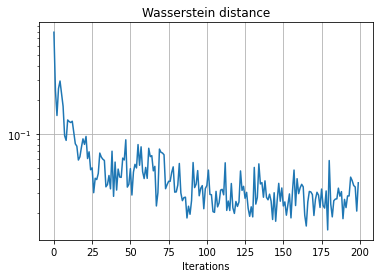

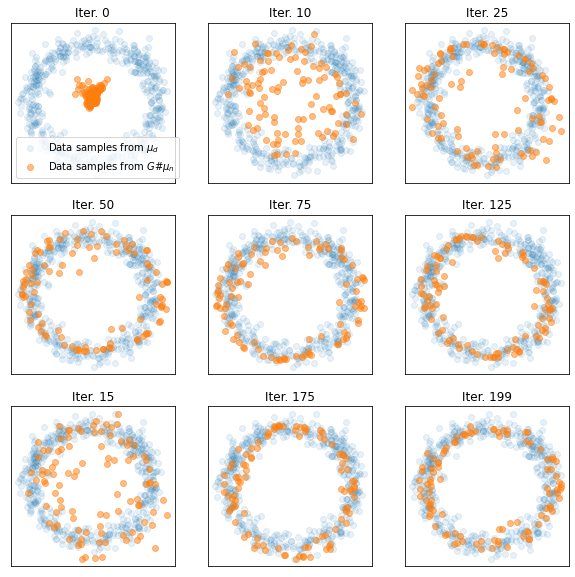

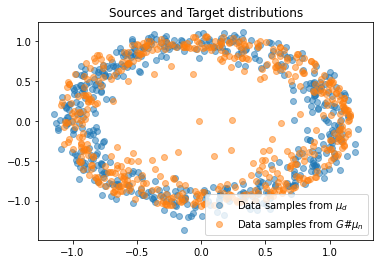

In [ ]:
losses, G, xvisu, xd = WGAN()
plot_losses(losses)
plot_trajectories(xd, xvisu)
plot_data(G)

## Approximated WGAN

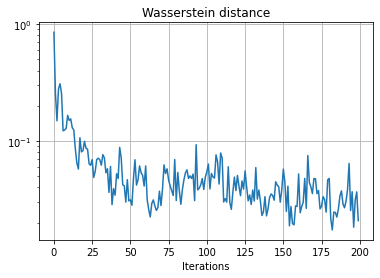

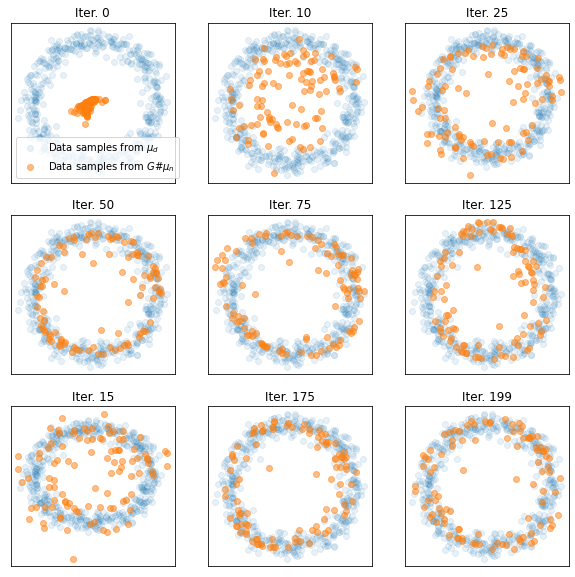

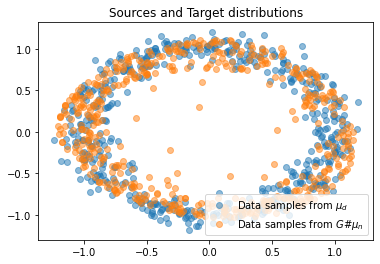

In [ ]:
p = 500
losses, G, xvisu, xd = WGAN_approx(p)
plot_losses(losses)
plot_trajectories(xd, xvisu)
plot_data(G)

## Evaluation of the approximation when the number of reference points changes

In [ ]:
loss_p = []
WGANS = []
n_points = [0, 1, 10, 20, 50, 500]
for p in n_points:
  if p == 0:
    losses, G, _, _ = WGAN()
  else:
    losses, G, _, _ = WGAN_approx(p)
  loss_p.append(losses)
  WGANS.append(G)

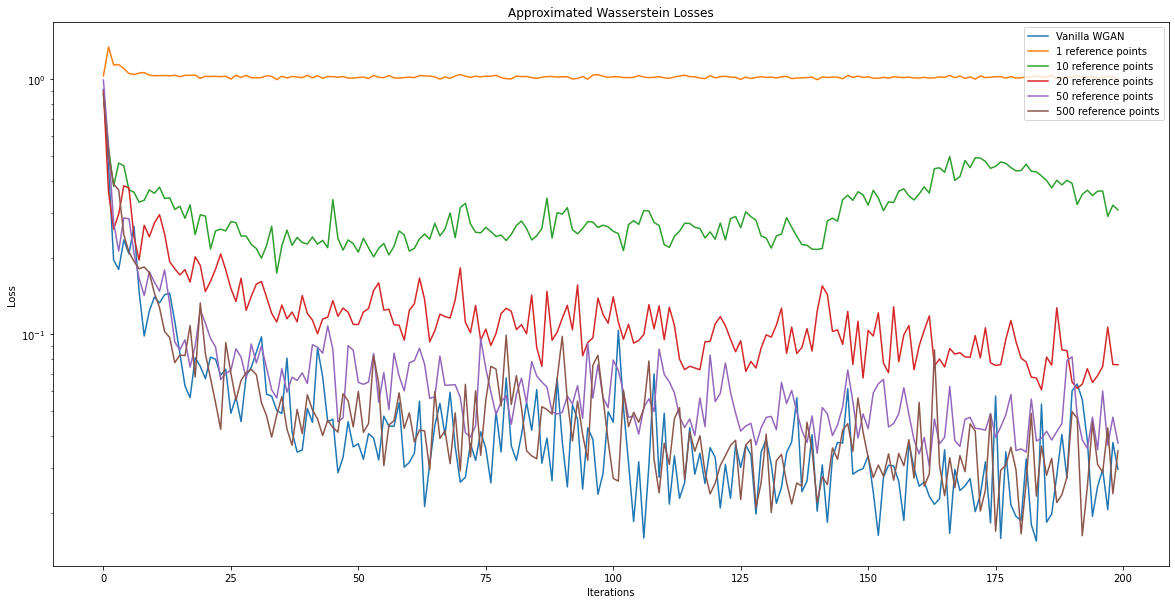

In [ ]:
pl.figure(1, (20,10))
pl.title('Wasserstein Losses')
for i,p in enumerate(n_points):
    losses = loss_p[i]
    if p == 0:
        pl.semilogy(losses, label='Vanilla WGAN')
    else:
        pl.semilogy(losses, label='{} reference points'.format(p))
    pl.grid()
    pl.xlabel("Iterations")
    pl.ylabel("Loss")
    pl.legend(loc='upper right')
pl.show()

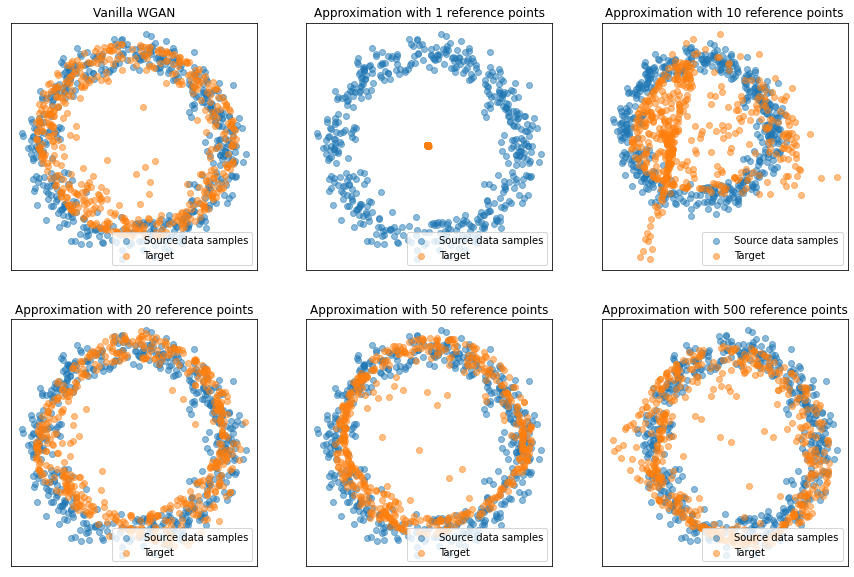

In [ ]:
size_batch = 500
xd = get_data(size_batch)
xn = get_random(size_batch) 
pl.figure(3, (15, 10))
for i,p in enumerate(n_points):
    pl.subplot(2, 3, i + 1)
    G = WGANS[i]
    x = G(xn).detach().numpy()
    pl.scatter(xd[:, 0], xd[:, 1], label='Source', alpha=0.5)
    pl.scatter(x[:, 0], x[:, 1], label='Target', alpha=0.5)
    pl.xticks(())
    pl.yticks(())
    if p == 0:
        pl.title('Vanilla WGAN')
    else:
        pl.title('Approximation with {} reference points'.format(p))
    pl.legend(loc='lower right')
pl.show()

## Comparison of Vanilla GAN and best approximation

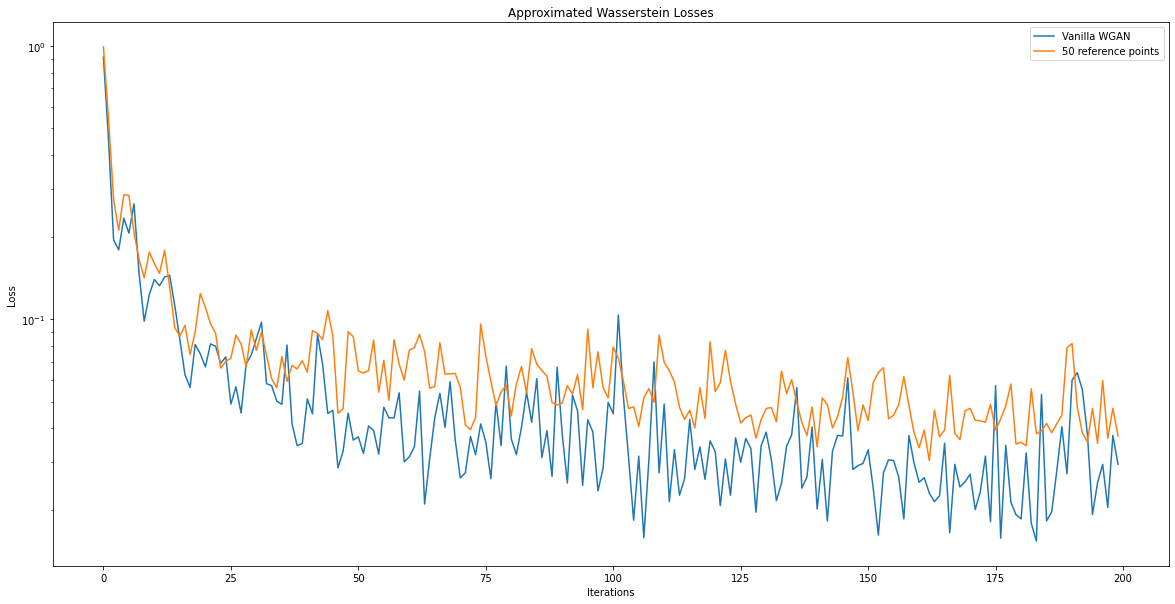

In [ ]:
pl.figure(1, (20,10))
pl.title('Wasserstein Losses')
selection = [(0,0),(-2,50)]
for i,p in selection:
    losses = loss_p[i]
    if p == 0:
        pl.semilogy(losses, label='Vanilla WGAN')
    else:
        pl.semilogy(losses, label='{} reference points'.format(p))
    pl.grid()
    pl.xlabel("Iterations")
    pl.ylabel("Loss")
    pl.legend(loc='upper right')
pl.show()

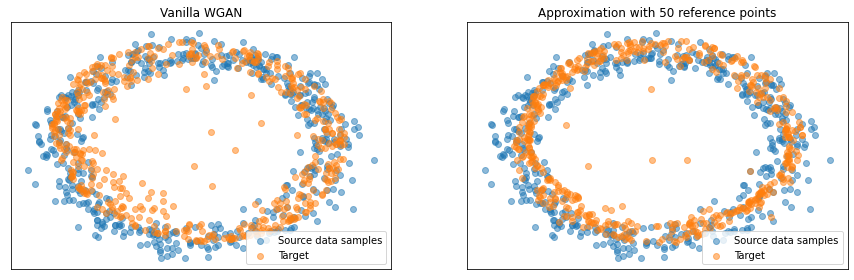

In [ ]:
size_batch = 500
xd = get_data(size_batch)
xn = get_random(size_batch) 
pl.figure(2, (15, 10))

pl.subplot(2,2,1)
G = WGANS[0]
x = G(xn).detach().numpy()
pl.scatter(xd[:, 0], xd[:, 1], label='Source', alpha=0.5)
pl.scatter(x[:, 0], x[:, 1], label='Target', alpha=0.5)
pl.xticks(())
pl.yticks(())
pl.title('Vanilla WGAN')
pl.legend(loc='lower right')

pl.subplot(2,2,2)
G = WGANS[-2]
x = G(xn).detach().numpy()
pl.scatter(xd[:, 0], xd[:, 1], label='Source', alpha=0.5)
pl.scatter(x[:, 0], x[:, 1], label='Target', alpha=0.5)
pl.xticks(())
pl.yticks(())
pl.title('Approximation with {} reference points'.format(n_points[-2]))
pl.legend(loc='lower right')

pl.show()

## We showed empirically that $W_2^z$ is a good proxy for $W_2$.
## We can see that a very low $p$ leads to a poor approximation and that from $p=50$, the approximation of the Wasserstein Distance is satisfying. Taking p too large does not bring additional improvement.

In [ ]:
### UILISER TQDM POU VISUALISER TRAINING EVOLUTION